In [42]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm

In [2]:
file_path = 'event_log_2.xes'
event_log = pm4py.read_xes(file_path)

parsing log, completed traces ::   0%|          | 0/1898 [00:00<?, ?it/s]

In [3]:
event_log

,concept:name,lifecycle:transition,time:timestamp,org:resource,case:concept:name
0,DIAGNOSIS,SCHEDULE,2020-01-01 14:34:18.820288+00:00,None,0
1,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0
2,DIAGNOSIS,COMPLETE,2020-01-01 15:21:28.088736+00:00,Joe,0
3,REPAIR,SCHEDULE,2020-01-01 15:21:28.088736+00:00,None,0
4,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0
...,...,...,...,...,...
17073,DIAGNOSIS,SCHEDULE,2024-12-29 15:20:35.710092+00:00,None,1897
17074,DIAGNOSIS,START,2024-12-29 15:20:35.710092+00:00,Joe,1897
17075,DIAGNOSIS,COMPLETE,2024-12-29 16:26:29.392744+00:00,Joe,1897
17076,REPAIR,SCHEDULE,2024-12-29 16:26:29.392744+00:00,None,1897


In [4]:
merged_event_log = pandas.merge(event_log, event_log,
                                left_on=['case:concept:name', 'org:resource', 'concept:name'],
                                right_on=['case:concept:name', 'org:resource', 'concept:name'],
                                suffixes=('_start', '_complete'))
start_end_event_log = merged_event_log[(merged_event_log['lifecycle:transition_start'] == 'START') & (merged_event_log['lifecycle:transition_complete'] == 'COMPLETE')]
start_end_event_log.loc[:, 'duration'] = start_end_event_log['time:timestamp_complete'] - start_end_event_log['time:timestamp_start']
start_end_event_log.loc[:, 'duration_seconds'] =  (start_end_event_log['duration']).astype('timedelta64[s]').astype(int)
start_end_event_log = start_end_event_log[start_end_event_log['duration_seconds'] > 0]
start_end_event_log

/tmp/ipykernel_16302/3138905879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_event_log.loc[:, 'duration'] = start_end_event_log['time:timestamp_complete'] - start_end_event_log['time:timestamp_start']
/tmp/ipykernel_16302/3138905879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_event_log.loc[:, 'duration_seconds'] =  (start_end_event_log['duration']).astype('timedelta64[s]').astype(int)


,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds
2,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0,COMPLETE,2020-01-01 15:21:28.088736+00:00,0 days 00:47:09.268448,2829
7,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0,COMPLETE,2020-01-01 19:13:00.804173+00:00,0 days 03:51:32.715437,13892
12,QUALITY_CONTROL,START,2020-01-01 19:13:00.804173+00:00,Karsten,0,COMPLETE,2020-01-01 23:05:15.854003+00:00,0 days 03:52:15.049830,13935
17,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041
22,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702
...,...,...,...,...,...,...,...,...,...
28437,QUALITY_CONTROL,START,2024-12-29 05:14:41.266911+00:00,1,1895,COMPLETE,2024-12-29 08:39:48.880273+00:00,0 days 03:25:07.613362,12307
28442,DIAGNOSIS,START,2024-12-29 02:01:06.488935+00:00,Karsten,1896,COMPLETE,2024-12-29 02:53:21.861276+00:00,0 days 00:52:15.372341,3135
28447,REPAIR,START,2024-12-29 02:53:21.861276+00:00,Karsten,1896,COMPLETE,2024-12-29 08:04:13.758573+00:00,0 days 05:10:51.897297,18651
28452,QUALITY_CONTROL,START,2024-12-29 08:04:13.758573+00:00,Karsten,1896,COMPLETE,2024-12-29 10:35:44.094365+00:00,0 days 02:31:30.335792,9090


In [104]:
# Seconds in day
start_end_event_log['seconds_in_day'] = start_end_event_log['time:timestamp_start'].dt.hour * 3600 + \
    start_end_event_log['time:timestamp_start'].dt.minute * 60 + \
    start_end_event_log['time:timestamp_start'].dt.second
start_end_event_log

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds,duration_sampled,seconds_in_day
2,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0,COMPLETE,2020-01-01 15:21:28.088736+00:00,0 days 00:47:09.268448,2829,4368,52458
7,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0,COMPLETE,2020-01-01 19:13:00.804173+00:00,0 days 03:51:32.715437,13892,16226,55288
12,QUALITY_CONTROL,START,2020-01-01 19:13:00.804173+00:00,Karsten,0,COMPLETE,2020-01-01 23:05:15.854003+00:00,0 days 03:52:15.049830,13935,10815,69180
17,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041,1833,64849
22,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702,16680,68891
...,...,...,...,...,...,...,...,...,...,...,...
28437,QUALITY_CONTROL,START,2024-12-29 05:14:41.266911+00:00,1,1895,COMPLETE,2024-12-29 08:39:48.880273+00:00,0 days 03:25:07.613362,12307,9404,18881
28442,DIAGNOSIS,START,2024-12-29 02:01:06.488935+00:00,Karsten,1896,COMPLETE,2024-12-29 02:53:21.861276+00:00,0 days 00:52:15.372341,3135,4176,7266
28447,REPAIR,START,2024-12-29 02:53:21.861276+00:00,Karsten,1896,COMPLETE,2024-12-29 08:04:13.758573+00:00,0 days 05:10:51.897297,18651,26679,10401
28452,QUALITY_CONTROL,START,2024-12-29 08:04:13.758573+00:00,Karsten,1896,COMPLETE,2024-12-29 10:35:44.094365+00:00,0 days 02:31:30.335792,9090,10547,29053


In [184]:
# Resource counts

resource_count = pandas.merge(start_end_event_log, start_end_event_log,
                              left_on=['case:concept:name'],
                              right_on=['case:concept:name'],
                              suffixes=('_first', '_second'))

resource_count = resource_count[resource_count['time:timestamp_start_first'] >= resource_count['time:timestamp_complete_second']]

resource_count = resource_count.groupby(['case:concept:name', 'concept:name_first',
                                         'time:timestamp_start_first', 'org:resource_second']).count()['lifecycle:transition_start_first'].reset_index()

resource_count[resource_count['lifecycle:transition_start_first'] == 2]

pt = pandas.pivot_table(resource_count, index=['case:concept:name', 'concept:name_first', 'time:timestamp_start_first'],
                        columns=['org:resource_second'],
                        values='lifecycle:transition_start_first', aggfunc='sum',
                        fill_value=0)

resource_count_event_log = pandas.merge(start_end_event_log, pt,
                 left_on=['case:concept:name', 'concept:name', 'time:timestamp_start'],
                 right_on=['case:concept:name', 'concept:name_first', 'time:timestamp_start_first'],
                how='left',
                suffixes=('_left', '_right'))
resource_count_event_log = resource_count_event_log.fillna(0)

In [185]:
resource_count_event_log

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds,duration_sampled,seconds_in_day,1,Clark,Jane,Joe,Karsten
0,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0,COMPLETE,2020-01-01 15:21:28.088736+00:00,0 days 00:47:09.268448,2829,4368,52458,0.0,0.0,0.0,0.0,0.0
1,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0,COMPLETE,2020-01-01 19:13:00.804173+00:00,0 days 03:51:32.715437,13892,16226,55288,0.0,0.0,0.0,1.0,0.0
2,QUALITY_CONTROL,START,2020-01-01 19:13:00.804173+00:00,Karsten,0,COMPLETE,2020-01-01 23:05:15.854003+00:00,0 days 03:52:15.049830,13935,10815,69180,1.0,0.0,0.0,1.0,0.0
3,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041,1833,64849,0.0,0.0,0.0,0.0,0.0
4,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702,16680,68891,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,QUALITY_CONTROL,START,2024-12-29 05:14:41.266911+00:00,1,1895,COMPLETE,2024-12-29 08:39:48.880273+00:00,0 days 03:25:07.613362,12307,9404,18881,1.0,0.0,0.0,1.0,0.0
5688,DIAGNOSIS,START,2024-12-29 02:01:06.488935+00:00,Karsten,1896,COMPLETE,2024-12-29 02:53:21.861276+00:00,0 days 00:52:15.372341,3135,4176,7266,0.0,0.0,0.0,0.0,0.0
5689,REPAIR,START,2024-12-29 02:53:21.861276+00:00,Karsten,1896,COMPLETE,2024-12-29 08:04:13.758573+00:00,0 days 05:10:51.897297,18651,26679,10401,0.0,0.0,0.0,0.0,1.0
5690,QUALITY_CONTROL,START,2024-12-29 08:04:13.758573+00:00,Karsten,1896,COMPLETE,2024-12-29 10:35:44.094365+00:00,0 days 02:31:30.335792,9090,10547,29053,0.0,0.0,0.0,0.0,2.0


In [187]:
# Previous activity counts

activity_count = pandas.merge(resource_count_event_log, resource_count_event_log,
                              left_on=['case:concept:name'],
                              right_on=['case:concept:name'],
                              suffixes=('_first', '_second'))

activity_count = activity_count[activity_count['time:timestamp_start_first'] >= activity_count['time:timestamp_complete_second']]

activity_count = activity_count.groupby(['case:concept:name', 'concept:name_first',
                                         'time:timestamp_start_first', 'concept:name_second']).count()['lifecycle:transition_start_first'].reset_index()

pt = pandas.pivot_table(activity_count, index=['case:concept:name', 'concept:name_first', 'time:timestamp_start_first'],
                        columns=['concept:name_second'],
                        values='lifecycle:transition_start_first', aggfunc='sum',
                       fill_value=0)

activity_count_event_log = pandas.merge(resource_count_event_log, pt,
                 left_on=['case:concept:name', 'concept:name', 'time:timestamp_start'],
                 right_on=['case:concept:name', 'concept:name_first', 'time:timestamp_start_first'],
                how='left',
                suffixes=('_left', '_right'))
activity_count_event_log = activity_count_event_log.fillna(0)

In [188]:
activity_count_event_log

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds,duration_sampled,seconds_in_day,1,Clark,Jane,Joe,Karsten,DIAGNOSIS,REPAIR
0,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0,COMPLETE,2020-01-01 15:21:28.088736+00:00,0 days 00:47:09.268448,2829,4368,52458,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0,COMPLETE,2020-01-01 19:13:00.804173+00:00,0 days 03:51:32.715437,13892,16226,55288,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,QUALITY_CONTROL,START,2020-01-01 19:13:00.804173+00:00,Karsten,0,COMPLETE,2020-01-01 23:05:15.854003+00:00,0 days 03:52:15.049830,13935,10815,69180,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041,1833,64849,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702,16680,68891,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,QUALITY_CONTROL,START,2024-12-29 05:14:41.266911+00:00,1,1895,COMPLETE,2024-12-29 08:39:48.880273+00:00,0 days 03:25:07.613362,12307,9404,18881,1.0,0.0,0.0,1.0,0.0,1.0,1.0
5688,DIAGNOSIS,START,2024-12-29 02:01:06.488935+00:00,Karsten,1896,COMPLETE,2024-12-29 02:53:21.861276+00:00,0 days 00:52:15.372341,3135,4176,7266,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5689,REPAIR,START,2024-12-29 02:53:21.861276+00:00,Karsten,1896,COMPLETE,2024-12-29 08:04:13.758573+00:00,0 days 05:10:51.897297,18651,26679,10401,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5690,QUALITY_CONTROL,START,2024-12-29 08:04:13.758573+00:00,Karsten,1896,COMPLETE,2024-12-29 10:35:44.094365+00:00,0 days 02:31:30.335792,9090,10547,29053,0.0,0.0,0.0,0.0,2.0,1.0,1.0


In [189]:
activity_count_event_log.to_csv('artificial_start_end_2.csv')

In [176]:
activity_count_event_log['org:resource'].unique()

array(['Joe', '1', 'Karsten', 'Jane', 'Clark'], dtype=object)

In [ ]:
# Evaluation

In [177]:
merged_event_log = pandas.merge(activity_count_event_log,
                                activity_count_event_log[['case:concept:name', 'time:timestamp_start']],
                                left_on=['case:concept:name'],
                                right_on=['case:concept:name'],
                                suffixes=('', '_case_start'))

start_end_start_case_event_log = merged_event_log.loc[merged_event_log.groupby(['case:concept:name', 'concept:name'])['time:timestamp_start_case_start'].idxmin()]

merged_event_log = pandas.merge(start_end_start_case_event_log,
                                start_end_start_case_event_log[['case:concept:name', 'time:timestamp_complete']],
                                left_on=['case:concept:name'],
                                right_on=['case:concept:name'],
                                suffixes=('', '_case_end'))

start_end_start_end_event_log = merged_event_log.loc[
    merged_event_log.groupby(['case:concept:name', 'concept:name'])['time:timestamp_complete_case_end'].idxmax()
]

start_end_start_end_event_log[start_end_start_end_event_log['case:concept:name'] == '1']
#merged_event_log[merged_event_log['case:concept:name'] == '1']

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds,duration_sampled,seconds_in_day,1,Clark,Jane,Joe,Karsten,DIAGNOSIS,REPAIR,time:timestamp_start_case_start,time:timestamp_complete_case_end
10,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041,1833,64849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 18:00:49.603934+00:00,2020-01-02 05:15:46.711023+00:00
13,QUALITY_CONTROL,START,2020-01-02 02:49:53.806536+00:00,Clark,1,COMPLETE,2020-01-02 05:15:46.711023+00:00,0 days 02:25:52.904487,8752,7796,10193,NaN,NaN,2.0,NaN,NaN,1.0,1.0,2020-01-01 18:00:49.603934+00:00,2020-01-02 05:15:46.711023+00:00
16,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702,16680,68891,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2020-01-01 18:00:49.603934+00:00,2020-01-02 05:15:46.711023+00:00


In [178]:
case_duration_log = start_end_start_end_event_log.copy()
case_duration_log['case_duration'] = case_duration_log['time:timestamp_complete_case_end'] - case_duration_log['time:timestamp_start_case_start']
case_duration_log['case_duration_seconds'] = (case_duration_log['case_duration']).astype('timedelta64[s]').astype(int)

case_duration_log = case_duration_log.loc[case_duration_log.groupby('case:concept:name')['concept:name'].idxmin()]

case_duration_log = case_duration_log[['case:concept:name', 'time:timestamp_start_case_start', 'time:timestamp_complete_case_end',
                                       'case_duration', 'case_duration_seconds']]

case_duration_log

,case:concept:name,time:timestamp_start_case_start,time:timestamp_complete_case_end,case_duration,case_duration_seconds
1,0,2020-01-01 14:34:18.820288+00:00,2020-01-01 23:05:15.854003+00:00,0 days 08:30:57.033715,30657
10,1,2020-01-01 18:00:49.603934+00:00,2020-01-02 05:15:46.711023+00:00,0 days 11:14:57.107089,40497
19,10,2020-01-12 19:59:05.590033+00:00,2020-01-13 04:05:56.716266+00:00,0 days 08:06:51.126233,29211
28,100,2020-04-14 17:44:17.288791+00:00,2020-04-15 06:19:23.628814+00:00,0 days 12:35:06.340023,45306
37,1000,2022-07-11 20:26:25.689092+00:00,2022-07-12 05:09:29.696467+00:00,0 days 08:43:04.007375,31384
...,...,...,...,...,...
17030,995,2022-07-08 12:18:31.622463+00:00,2022-07-08 20:57:29.375155+00:00,0 days 08:38:57.752692,31137
17039,996,2022-07-09 00:20:25.132683+00:00,2022-07-09 19:02:42.462973+00:00,0 days 18:42:17.330290,67337
17048,997,2022-07-09 21:28:13.585886+00:00,2022-07-10 05:16:39.512122+00:00,0 days 07:48:25.926236,28105
17057,998,2022-07-10 07:48:58.547047+00:00,2022-07-10 20:58:08.635270+00:00,0 days 13:09:10.088223,47350


<Axes: >

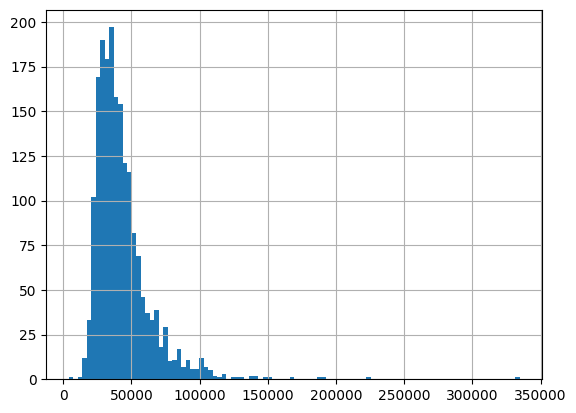

In [40]:
case_duration_log['case_duration_seconds'].hist(bins=100)

In [48]:
from models.artificial_new.parser import *

In [49]:
os.chdir("/home/michel/Documents/TaskExecutionTimeMining/src/notebooks/models/artificial_new")
p = Parser()
mean_cut_variables, mean_trees = p.parse_mean()
prec_cut_variables, prec_trees = p.parse_prec()
phi_star = p.parse_phistar()
ucuts = p.parse_ucuts()
encoding = p.parse_encoding()
at = AllTrees(mean_trees, prec_trees)


In [50]:
start_end_event_log['duration_sampled'] = r['org:resource'] for r in start_end_event_log

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds
2,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0,COMPLETE,2020-01-01 15:21:28.088736+00:00,0 days 00:47:09.268448,2829
7,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0,COMPLETE,2020-01-01 19:13:00.804173+00:00,0 days 03:51:32.715437,13892
12,QUALITY_CONTROL,START,2020-01-01 19:13:00.804173+00:00,Karsten,0,COMPLETE,2020-01-01 23:05:15.854003+00:00,0 days 03:52:15.049830,13935
17,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041
22,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702
...,...,...,...,...,...,...,...,...,...
28437,QUALITY_CONTROL,START,2024-12-29 05:14:41.266911+00:00,1,1895,COMPLETE,2024-12-29 08:39:48.880273+00:00,0 days 03:25:07.613362,12307
28442,DIAGNOSIS,START,2024-12-29 02:01:06.488935+00:00,Karsten,1896,COMPLETE,2024-12-29 02:53:21.861276+00:00,0 days 00:52:15.372341,3135
28447,REPAIR,START,2024-12-29 02:53:21.861276+00:00,Karsten,1896,COMPLETE,2024-12-29 08:04:13.758573+00:00,0 days 05:10:51.897297,18651
28452,QUALITY_CONTROL,START,2024-12-29 08:04:13.758573+00:00,Karsten,1896,COMPLETE,2024-12-29 10:35:44.094365+00:00,0 days 02:31:30.335792,9090


In [90]:
start_end_event_log['duration_sampled'] = start_end_event_log.apply(lambda x : int(round(
                                                                        sample(p.get_encodings([[x['org:resource'], x['concept:name']]])[0],
                                                                                                     1,
                                                                                                     at,
                                                                                                     ucuts,
                                                                                                     phi_star)[0],
                                                                                0)), axis=1)

In [85]:
start_end_event_log

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds,duration_sampled
2,DIAGNOSIS,START,2020-01-01 14:34:18.820288+00:00,Joe,0,COMPLETE,2020-01-01 15:21:28.088736+00:00,0 days 00:47:09.268448,2829,4293.0
7,REPAIR,START,2020-01-01 15:21:28.088736+00:00,1,0,COMPLETE,2020-01-01 19:13:00.804173+00:00,0 days 03:51:32.715437,13892,20751.0
12,QUALITY_CONTROL,START,2020-01-01 19:13:00.804173+00:00,Karsten,0,COMPLETE,2020-01-01 23:05:15.854003+00:00,0 days 03:52:15.049830,13935,9746.0
17,DIAGNOSIS,START,2020-01-01 18:00:49.603934+00:00,Jane,1,COMPLETE,2020-01-01 19:08:11.564364+00:00,0 days 01:07:21.960430,4041,2451.0
22,REPAIR,START,2020-01-01 19:08:11.564364+00:00,Jane,1,COMPLETE,2020-01-02 02:49:53.806536+00:00,0 days 07:41:42.242172,27702,56095.0
...,...,...,...,...,...,...,...,...,...,...
28437,QUALITY_CONTROL,START,2024-12-29 05:14:41.266911+00:00,1,1895,COMPLETE,2024-12-29 08:39:48.880273+00:00,0 days 03:25:07.613362,12307,10006.0
28442,DIAGNOSIS,START,2024-12-29 02:01:06.488935+00:00,Karsten,1896,COMPLETE,2024-12-29 02:53:21.861276+00:00,0 days 00:52:15.372341,3135,4803.0
28447,REPAIR,START,2024-12-29 02:53:21.861276+00:00,Karsten,1896,COMPLETE,2024-12-29 08:04:13.758573+00:00,0 days 05:10:51.897297,18651,15138.0
28452,QUALITY_CONTROL,START,2024-12-29 08:04:13.758573+00:00,Karsten,1896,COMPLETE,2024-12-29 10:35:44.094365+00:00,0 days 02:31:30.335792,9090,14442.0


In [91]:
case_duration_simulated_log = start_end_event_log.copy()
cased_duration_simulated = case_duration_simulated_log.groupby('case:concept:name')['duration_sampled'].sum()

In [87]:
case_duration_log['case_duration_seconds']

1        30657
10       40497
19       29211
28       45306
37       31384
         ...  
17030    31137
17039    67337
17048    28105
17057    47350
17066    39427
Name: case_duration_seconds, Length: 1898, dtype: int64

In [88]:
cased_duration_simulated

case:concept:name
0       34790.0
1       66531.0
10      41057.0
100     38786.0
1000    30980.0
         ...   
995     75708.0
996     60015.0
997     35377.0
998     21650.0
999     54725.0
Name: duration_sampled, Length: 1898, dtype: float64

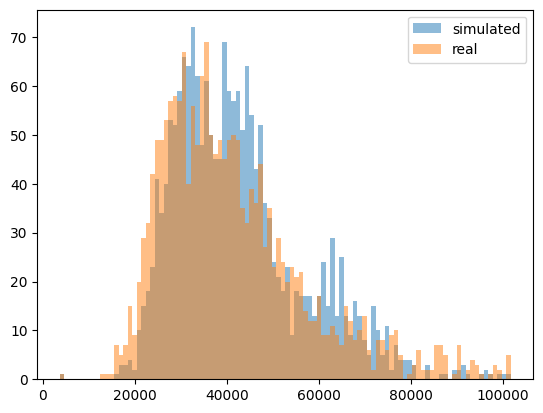

In [98]:
bins = 100
r = plt.hist(cased_duration_simulated, bins, alpha=0.5, label='simulated')
plt.hist(case_duration_log['case_duration_seconds'], r[1], alpha=0.5, label='real')
plt.legend(loc='upper right')
plt.show()